In [39]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [48]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set num of classes

In [59]:
NUM_CLASSES = 26

# Read dataset

In [60]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [61]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Build model

In [63]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [64]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_8 (Dropout)             │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 26)             │           286 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,356 (5.30 KB)

 Trainable params: 1,356 (5.30 KB)

 Non-trainable params: 0 (0.00 B)

In [65]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [66]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train model

In [67]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0351 - loss: 3.3418
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.0351 - loss: 3.3418 - val_accuracy: 0.0256 - val_loss: 3.2645
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.0263 - loss: 3.3216
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.0263 - loss: 3.3216 - val_accuracy: 0.0513 - val_loss: 3.2513
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0702 - loss: 3.3237
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.0702 - loss: 3.3237 - val_accuracy: 0.0513 - val_loss: 3.2385
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.0614 - loss: 3.2990
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras
1/1 ━━━━━━━━

In [68]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9231 - loss: 0.2119


In [69]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [70]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
[4.2357901e-03 2.7784158e-02 9.4070840e-01 2.7154583e-02 7.3451946e-07
 6.1776694e-07 9.2085554e-07 2.3455450e-06 2.8194869e-08 1.5925189e-05
 6.0360176e-06 1.5001499e-06 6.2691879e-07 4.8742135e-07 7.8825661e-07
 3.2020259e-06 4.6401706e-07 9.7745215e-06 5.0540788e-05 1.8740209e-05
 8.9080692e-07 1.9297955e-08 1.9728360e-07 2.8859945e-06 2.2395983e-07
 7.2063791e-08]
2


# Confusion matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


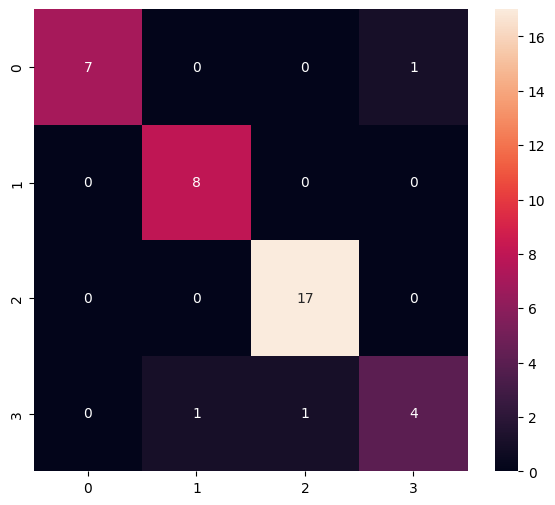

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.93         8
           1       0.89      1.00      0.94         8
           2       0.94      1.00      0.97        17
           3       0.80      0.67      0.73         6

    accuracy                           0.92        39
   macro avg       0.91      0.89      0.89        39
weighted avg       0.92      0.92      0.92        39



In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model (for Tensorflow-Lite)

In [72]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [73]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\endpl\AppData\Local\Temp\tmpxe9itlhi\assets


INFO:tensorflow:Assets written to: C:\Users\endpl\AppData\Local\Temp\tmpxe9itlhi\assets


Saved artifact at 'C:\Users\endpl\AppData\Local\Temp\tmpxe9itlhi'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 26), dtype=tf.float32, name=None)
Captures:
  2398065720160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2398066493040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2398065712944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2398066492864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2398066504832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2398069855984: TensorSpec(shape=(), dtype=tf.resource, name=None)


7540

# Inference test

In [74]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

c:\Users\endpl\anaconda3\envs\asl_env\lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [75]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [76]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [77]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 15.6 ms
Wall time: 5.15 ms


In [78]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[4.2357906e-03 2.7784172e-02 9.4070846e-01 2.7154578e-02 7.3452014e-07
 6.1776819e-07 9.2085645e-07 2.3455452e-06 2.8194924e-08 1.5925189e-05
 6.0360176e-06 1.5001511e-06 6.2691879e-07 4.8742135e-07 7.8825741e-07
 3.2020289e-06 4.6401703e-07 9.7745315e-06 5.0540784e-05 1.8740229e-05
 8.9080868e-07 1.9297957e-08 1.9728378e-07 2.8859943e-06 2.2395984e-07
 7.2063941e-08]
2
